In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
color_back = 'lightgray'
color_front = 'mediumseagreen'
SEED=42

from IPython.display import clear_output

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
pd.options.display.width = 2000
pd.options.display.max_colwidth = 2000

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/multiple_choice_responses.csv', header=1)
_ = df.pop('Duration (in seconds)')

df.rename(columns={'What is your gender? - Selected Choice': 'Gender'}, inplace=True)
country_col = 'In which country do you currently reside?'
df.loc[df[country_col]=='United States of America', country_col] = 'USA'
df.loc[df[country_col]=='United Kingdom of Great Britain and Northern Ireland', country_col] = 'UK'
df.loc[df[country_col]=='Iran, Islamic Republic of...', country_col] = 'Iran'

job_title_col = 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice'

# Gender ratio

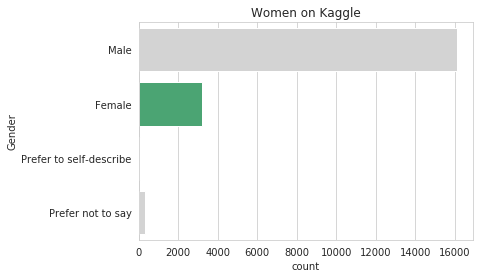

In [3]:
sns.countplot(y='Gender', data=df, palette=[color_back, color_front, color_back, color_back])
plt.title('Women on Kaggle');

# Gender ratio across countries

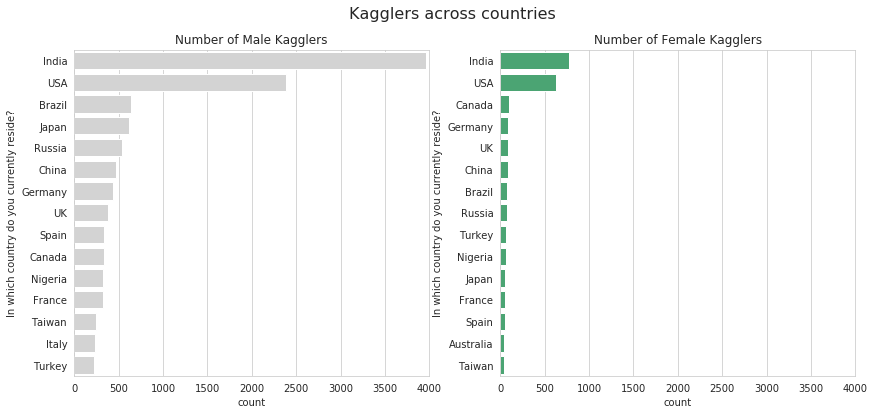

In [4]:
df = df.loc[df['Gender'].isin(['Female', 'Male'])]
df_women_countries = df.loc[df['Gender']=='Female', :]
df_women_countries = df_women_countries.loc[df_women_countries[country_col]!='Other', :]

df_men_countries = df.loc[df['Gender']=='Male', :]
df_men_countries = df_men_countries.loc[df_men_countries[country_col]!='Other', :]

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1)
sns.countplot(y=country_col, 
              data=df_men_countries, 
              order=df_men_countries[country_col].value_counts().iloc[:15].index, 
              color=color_back)
ax1.set_xlim(0, 4000)
ax1.set_title('Number of Male Kagglers');

ax2 = fig.add_subplot(1, 2, 2)
sns.countplot(y=country_col, 
              data=df_women_countries, 
              order=df_women_countries[country_col].value_counts().iloc[:15].index, 
              color=color_front)
ax2.set_xlim(0, 4000)
ax2.set_title('Number of Female Kagglers')
plt.suptitle('Kagglers across countries', fontsize=16);

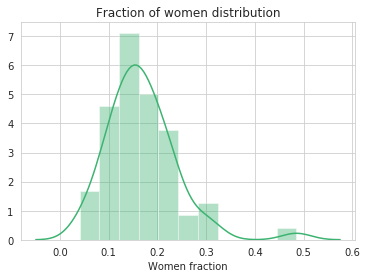

In [5]:
df_country_count = pd.DataFrame(df[country_col].value_counts())
df_country_count.rename(columns={'index': 'Country', country_col: 'Count'}, inplace=True)

df_women_country_count = pd.DataFrame(df.loc[df['Gender']=='Female', country_col].value_counts())
df_women_country_count.rename(columns={'index': 'Country', country_col: 'Women count'}, inplace=True)

df_country_count = df_country_count.join(df_women_country_count)
df_country_count['Women fraction'] = df_country_count['Women count'] / df_country_count['Count']
df_country_count.pop('Count')
df_country_count.pop('Women count')
df_country_count = df_country_count.sort_values(by='Women fraction', ascending=False).reset_index()

sns.distplot(df_country_count['Women fraction'], color=color_front)
plt.title('Fraction of women distribution');

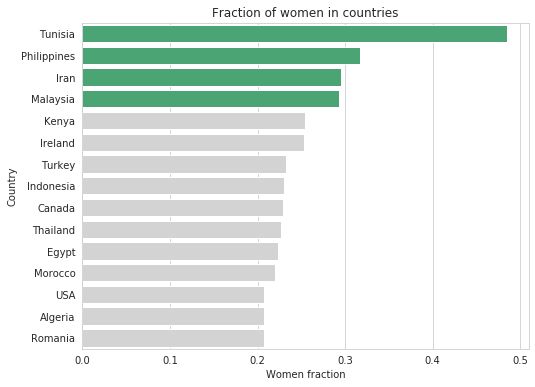

In [55]:
fig = plt.figure(figsize=(8, 6))
sns.barplot(data=df_country_count, 
            x='Women fraction', 
            y='index', 
            order=df_country_count['index'].iloc[:15],
            palette=[color_front for _ in range(4)] + [color_back for _ in range(11)])
plt.ylabel('Country')
plt.title('Fraction of women in countries');

# Gender ratio across roles

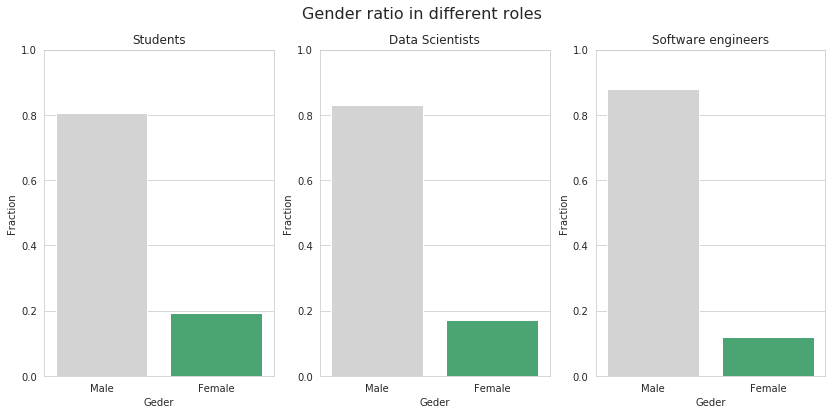

In [7]:
data_science_jobs = ['Data Scientist', 'Data Analyst', 'Research Scientist', 'Statistician']
df_ds_jobs = df.loc[df[job_title_col].isin(data_science_jobs)]
df_students = df.loc[df[job_title_col]=='Student']
se_jobs = ['Data Engineer', 'Software Engineer']
df_se_jobs = df.loc[df[job_title_col].isin(se_jobs)]

fig = plt.figure(figsize=(14, 6))

# Students
ax1 = fig.add_subplot(1, 3, 1)
sns.barplot(x='Gender', 
            y='Gender', 
            data=df_students, 
            estimator=lambda x: len(x) / len(df_students), 
            orient='v', 
            palette=[color_back, color_front, color_back, color_back])
ax1.set_xlabel('Geder')
ax1.set_ylabel('Fraction')
ax1.set_ylim(0.0, 1.0)
ax1.set_title('Students')

# Data Science
ax2 = fig.add_subplot(1, 3, 2)
sns.barplot(x='Gender', 
            y='Gender', 
            data=df_ds_jobs, 
            estimator=lambda x: len(x) / len(df_ds_jobs), 
            orient='v', 
            palette=[color_back, color_front, color_back, color_back])
ax2.set_xlabel('Geder')
ax2.set_ylabel('Fraction')
ax2.set_ylim(0.0, 1.0)
ax2.set_title('Data Scientists');

# Software engineering
ax3 = fig.add_subplot(1, 3, 3)
sns.barplot(x='Gender', 
            y='Gender', 
            data=df_se_jobs, 
            estimator=lambda x: len(x) / len(df_se_jobs), 
            orient='v', 
            palette=[color_back, color_front, color_back, color_back])
ax3.set_xlabel('Geder')
ax3.set_ylabel('Fraction')
ax3.set_ylim(0.0, 1.0)
ax3.set_title('Software engineers')
plt.suptitle('Gender ratio in different roles', fontsize=16);

# Women salaries

In [9]:
# Salary preprocessing
salary_column = 'What is your current yearly compensation (approximate $USD)?'
salary_type = CategoricalDtype(categories=["$0-999", "1,000-1,999", "2,000-2,999", "3,000-3,999", "4,000-4,999",
                                           "5,000-7,499", "7,500-9,999", "10,000-14,999", "15,000-19,999",
                                           "20,000-24,999", "25,000-29,999", "30,000-39,999", "40,000-49,999",
                                           "50,000-59,999", "60,000-69,999", "70,000-79,999", "80,000-89,999",
                                           "200,000-249,999", "250,000-299,999", "300,000-500,000", "> $500,000"],
                               ordered=True)
df[salary_column] = df[salary_column].astype(salary_type)

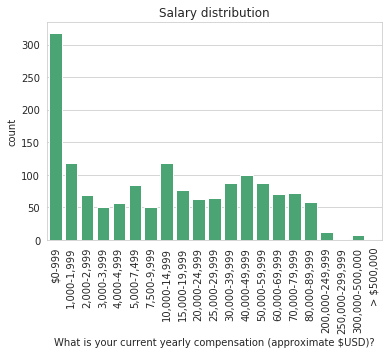

In [20]:
df_women = df.loc[df['Gender']=='Female', :]
sns.countplot(data=df_women, x=salary_column, color=color_front)
plt.xticks(rotation=90)
plt.title('Salary distribution');

# Sociodemographics

In [48]:
# Age preprocessing
age_column = 'What is your age (# years)?'
age_type = CategoricalDtype(categories=['18-21', '22-24', '25-29', '30-34', '35-39', '40-44', 
                                        '45-49', '50-54', '55-59', '60-69', '70+'], ordered=True)
df[age_column] = df[age_column].astype(age_type)

# Experience preprocessing
experience_column = 'How long have you been writing code to analyze data (at work or at school)?'
experience_type = CategoricalDtype(categories=['< 1 years', '1-2 years', '3-5 years', '5-10 years', 
                                               '10-20 years', '20+ years'], ordered=True)
df[experience_column] = df[experience_column].astype(experience_type)

# Education preprocessing
education_column = 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?'
df.loc[df[education_column]=='Some college/university study without earning a bachelor’s degree', education_column] = 'Some university study, no degree'

df_women = df.loc[df['Gender']=='Female', :]

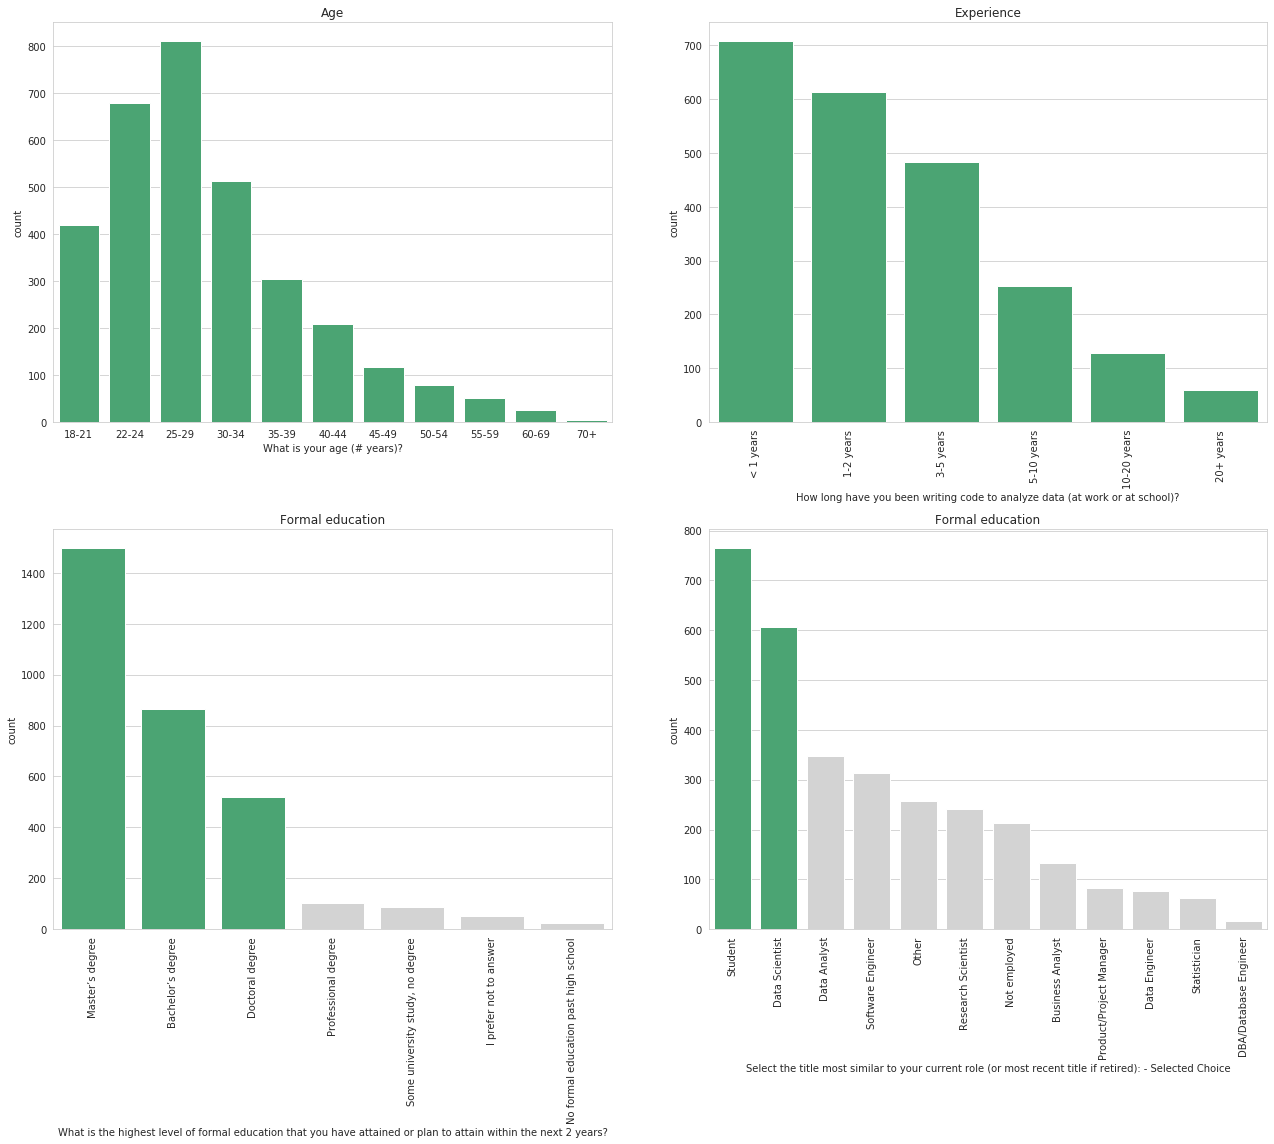

In [54]:
fig = plt.figure(figsize=(18, 16))

ax1 = fig.add_subplot(2, 2, 1)
sns.countplot(data=df_women, x=age_column, color=color_front)
ax1.set_title('Age')

ax2 = fig.add_subplot(2, 2, 2)
sns.countplot(data=df_women, x=experience_column, color=color_front)
ax2.set_title('Experience')
plt.xticks(rotation=90)

ax3 = fig.add_subplot(2, 2, 3)
sns.countplot(data=df_women, 
              x=education_column, 
              order=df_women[education_column].value_counts().index,
              palette=[color_front for _ in range(3)] + [color_back for _ in range(6)])
plt.xticks(rotation=90)
ax3.set_ylabel('count')
ax3.set_title('Formal education')

ax4 = fig.add_subplot(2, 2, 4)
sns.countplot(data=df_women, 
              x=job_title_col, 
              order=df_women[job_title_col].value_counts().index,
              palette=[color_front for _ in range(2)] + [color_back for _ in range(10)])
plt.xticks(rotation=90)
ax4.set_ylabel('count')
ax4.set_title('Formal education')

plt.tight_layout();